# GW cosmography with standard sirens
## A mock analysis

In this notebook, we will perform the Bayesian analysis following the paper [The Hitchhiker's guide to the galaxy catalog approach for gravitational wave cosmology](https://arxiv.org/abs/2212.08694). Their approach is implemented here in the [`SimplifiedLikelihood` class](./likelihood.py).

We use the GLADE+ catalog for the redshift information. For the GW data, we make the assumption that the GW signals come from the galaxies within the catalog, and draw (at random) a value of $z$ for a particular galaxy in the catalog with $z < 1.4$, following the methodology in the paper.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp
from catalog.utils import GalaxyCatalog
from inference.likelihood import SimplifiedLikelihood

### Simplification 1: negligible galaxy redshift error

In this section, we compute the posterior probability $p(H_0 | d_{\text{GW}}) \propto p(d_{\text{GW}} | H_0)p(H_0)$ under the assumption that the true galaxy redshifts are known (i.e that we made a perfect measurement). The single event likelihood becomes

\begin{equation}
p(d_i | H_0) = 
\frac{\sum_i^{N_\text{gal}} p(d_i | d_L(\hat{z}^i_\text{gal}, H_0))}{\sum_i^{N_\text{gal}} P^{\text{GW}}_{\text{det}}(\hat{z}^i_\text{gal}, H_0)}
\end{equation}

which corresponds to Eq. (15) of the paper.

We start by loading the catalog:

In [2]:
filename = "./catalog/output.hdf5"
catalog = GalaxyCatalog(filename)

We draw a set of sky directions $\{(\theta_i, \varphi_i)\}$ and we consider circular patches with a $5\degree$ angular radius for each of them, which we consider as the GW localisation area. We select all galaxies within each patch up to $z_\text{max}=1.4$, and we draw $N_{\text{GW}}=10$ events for each of them.

7801 galaxies selected in direction 1
6896 galaxies selected in direction 2


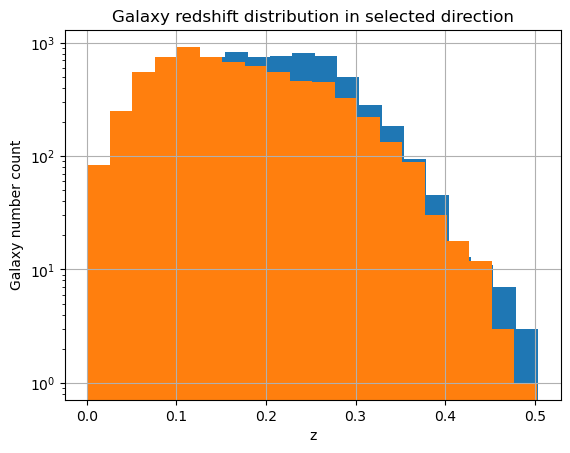

In [27]:
z_max = 1.4
n_dir = 2
n_gw_per_dir = 50
angular_radius  = np.radians(2)

# Draw sky directions
theta = np.random.uniform(0, np.pi / 2, n_dir)
phi = np.random.uniform(0, 2 * np.pi, n_dir)
gw_loc_centers = np.array([hp.ang2vec(theta_i, phi_i) for theta_i, phi_i in zip(theta, phi)])

# Get corresponding HEALPIX pixels
ipix_within_gw_locs = [
    hp.query_disc(nside=catalog.nside, vec=center, radius=angular_radius)
    for center in gw_loc_centers
]

# Get corresponding galaxy redshifts
z_gal = [
    catalog.z_at_index(ipix_within_gw_loc)
    for ipix_within_gw_loc in ipix_within_gw_locs
]
for i, z_gal_in_dir in enumerate(z_gal):
    print(f"{len(z_gal_in_dir)} galaxies selected in direction {i + 1}")
    plt.hist(z_gal_in_dir, bins=20, log=True)
plt.xlabel('z')
plt.ylabel('Galaxy number count')
plt.title('Galaxy redshift distribution in selected direction')
plt.grid()
plt.show()

Drawing GW events:

45 detections in direction 1
47 detections in direction 2
Luminosity distance treshold: 1550 Mpc


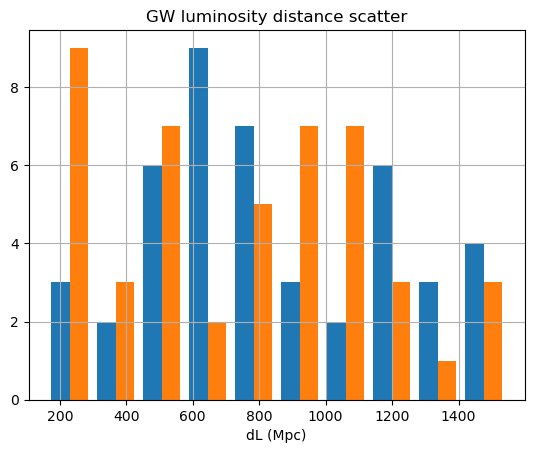

In [28]:
fiducial_H0 = 70.
lkh = SimplifiedLikelihood(ignore_z_error=True, fiducial_H0=fiducial_H0)
gw_dl_array = [lkh.draw_gw_events(z_gal_i, n_gw_per_dir) for z_gal_i in z_gal]
for i, gw_dl in enumerate(gw_dl_array):
    print(f"{len(gw_dl)} detections in direction {i + 1}")
#lkh.dl_th = np.median(gw_dl_array)
print(f"Luminosity distance treshold: {int(lkh.dl_th)} Mpc")
plt.hist(gw_dl_array)
plt.xlabel('dL (Mpc)')
plt.title('GW luminosity distance scatter')
plt.grid()
plt.show()


Below we plot the correction due to selection effects, which corresponds to the ratio between the expected detected number of events, $N_\text{det}$, and the total events, $N$. We see that, for high $H_0$, the fraction of events that are actually detected tends to 0.

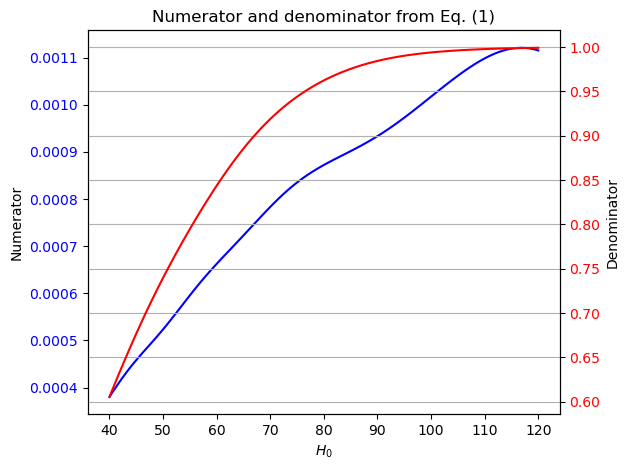

In [29]:
n_H0 = 100
H0_array = np.linspace(40., 120., n_H0)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(H0_array, lkh.gw_likelihood_array(gw_dl_array[1][2], H0_array, z_gal[0]), color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.plot(H0_array, lkh.selection_effects(H0_array, z_gal[1]), color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Numerator and denominator from Eq. (1)')
ax1.set_xlabel(r'$H_0$')
ax1.set_ylabel('Numerator')
ax2.set_ylabel('Denominator')
fig.tight_layout()
plt.grid()
plt.show()

Building the likelihood:

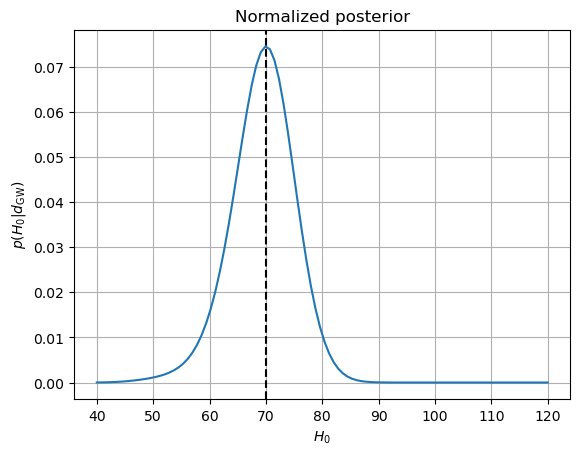

In [30]:
likelihood, matrix = lkh.likelihood(gw_dl_array, H0_array, z_gal, n_dir=n_dir)
plt.plot(H0_array, likelihood)
plt.axvline(fiducial_H0, ls='--', c='k')
plt.grid()
plt.title("Normalized posterior")
plt.xlabel(r"$H_0$")
plt.ylabel(r"$p(H_0 | d_\text{GW})$")
plt.show()